In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
from pathlib2 import Path
from glob import glob


### Чтение данных

In [2]:
def create_folders_lists(main_path):
    images_folders = []
    events_folders = []
    folder_names = []
    for folder_name in os.listdir(main_path):
        folder_names.append(folder_name)
        folder_path = os.path.join(main_path, folder_name)
        subfolders = os.listdir(folder_path)
        events_folder_path = os.path.join(folder_path, subfolders[0])
        images_folder_path = os.path.join(folder_path, subfolders[1])

        images_folders.append(images_folder_path)
        events_folders.append(events_folder_path)

    return images_folders, events_folders, folder_names

In [3]:
def read_dataframe(folder, name_dataset):
    data = []
    image_names = natsorted(os.listdir(folder))  
    for image_name in image_names:
        image_path = os.path.join(folder, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image_data = {
            'dataset': name_dataset,
            'image_name': image_name,
            'image_path': image_path,
            'image_size': image.shape}
        data.append(image_data)
    df = pd.DataFrame(data)
    return df

### 6.3 средняя площадь области в зависимости от времени.

In [4]:

   
def calculate_white_area_stats(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    contours = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    white_areas_count = 0
    total_area = 0

    for contour in contours:
        area = cv2.contourArea(contour)
        white_areas_count += 1
        total_area += area
    
    spatial_scale = 5.1
    avg_area_in_pixels = total_area / white_areas_count if white_areas_count > 0 else 0
    avg_area_in_mkm = avg_area_in_pixels / (spatial_scale ** 2) if avg_area_in_pixels > 0 else 0 
   
    return white_areas_count, avg_area_in_mkm



def add_white_area_info_to_df(df):
 
    white_areas_count = []
    average_areas = []
    for image_path in df['image_path']:
        result_function_1 = calculate_white_area_stats(image_path)  
        white_areas_count.append(result_function_1[0])
        average_areas.append(result_function_1[1])
    
    df['white_areas_count'] = white_areas_count
    df['average_area'] = average_areas
    
    return df


def graph_average_area(df):

    df['time_seconds'] = df.index / 2

    gragh = plt.figure(figsize=(6.49, 3.37), dpi=300)   
    plt.plot(df['time_seconds'], df['average_area'], color='#7B68EE', linewidth=3)
    plt.xlabel('Время, c')
    plt.ylabel('Средняя площадь области, мкм²')
    plt.title('Средняя площадь области в зависимости от времени')
    plt.xlim(df['time_seconds'].min(), df['time_seconds'].max())
    plt.ylim(df['average_area'].min(), df['average_area'].max())
    plt.legend(['Средняя площадь'], loc='upper right')
    plt.tight_layout()
    plt.show()
    return gragh

def save_graph(gragh, name_graph_png, name_graph_svg):
    gragh.savefig(name_graph_png)
    gragh.savefig(name_graph_svg)

def save_data_average_area(df, name_table):
    time_average_area_df = df[['time_seconds', 'average_area']].copy()
    print(time_average_area_df)
    time_average_area_df.to_excel(name_table)

### 6.8. число: средний уровень светимости внутри кальциевого события, усреднение по всем кадрам.

In [5]:
def calculate_mean_luminosity(images_folders, events_folders):

    mean_luminosity = []
    for i, events_folder in enumerate(events_folders): 
        event_files = natsorted(os.listdir(events_folder)) 
        images_folder = images_folders[i] 
        image_files = natsorted(os.listdir(images_folder)) 
        total_luminosity = 0 
        
        for j, event_image in enumerate(event_files): 
            event_image_path = os.path.join(events_folder, event_image) 
            event_image_data = cv2.imread(event_image_path, cv2.IMREAD_GRAYSCALE) 
            white_pixels = np.where(event_image_data > 0) 
            
            image_image = image_files[j] 
            image_image_path = os.path.join(images_folder, image_image) 
            image_image_data = cv2.imread(image_image_path, cv2.IMREAD_GRAYSCALE)
            luminosity = np.mean(image_image_data[white_pixels])
            total_luminosity += luminosity
        mean_luminosity.append(total_luminosity / len(event_files)) 
    
    return mean_luminosity #


def create_luminosity_dataframe(folder_names, mean_luminosity):
    df = pd.DataFrame({
        'Folder Name': folder_names,
        'Mean Luminosity': mean_luminosity
    })
    return df

def save_luminosity_to_excel(mean_luminosity, folder_names, file_name='luminosity.xlsx'):

    # Создаем DataFrame с данными
    df = create_luminosity_dataframe(folder_names, mean_luminosity)
    # Сохраняем DataFrame в файл Excel
    df.to_excel(file_name, index=False)
    
    print(f"Data saved to {file_name}")

In [6]:
def create_luminosity_dataframe(folder_names, mean_luminosity):
    df = pd.DataFrame({
        'Folder Name': folder_names,
        'Mean Luminosity': mean_luminosity
    })
    return df

### Запуск всех функций

In [9]:
def run_all_functions(main_path):
    images_folders, events_folders, folder_names = create_folders_lists(main_path)
    
    for i in range(len(events_folders)):
        df = read_dataframe(events_folders[i], folder_names[i])
        df_with_white_area = add_white_area_info_to_df(df)
        graph = graph_average_area(df_with_white_area)

        mean_luminosity = calculate_mean_luminosity([images_folders[i]], [events_folders[i]], [folder_names[i]])
        print("Mean Luminosity for folder:", f"{folder_names[i]}: = {mean_luminosity[0]}")

        folder_name = folder_names[i]
        path_to_save = rf'C:\Astro\results\{folder_name}'

        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)

        os.chdir(path_to_save)

        save_graph(graph, f"graph_{folder_names[i]}.png", f"graph_{folder_names[i]}.svg")
        save_data_average_area(df_with_white_area, f"data_{folder_names[i]}.xlsx")
        save_luminosity_to_excel([mean_luminosity], [folder_names[i]], f"luminosity_{folder_names[i]}.xlsx")
        
        common_mean_luminosity = calculate_mean_luminosity(images_folders, events_folders, folder_names)
        common_luminosity_df = create_luminosity_dataframe(folder_names, common_mean_luminosity)
        save_luminosity_to_excel(common_mean_luminosity, folder_names)
    print(common_luminosity_df)

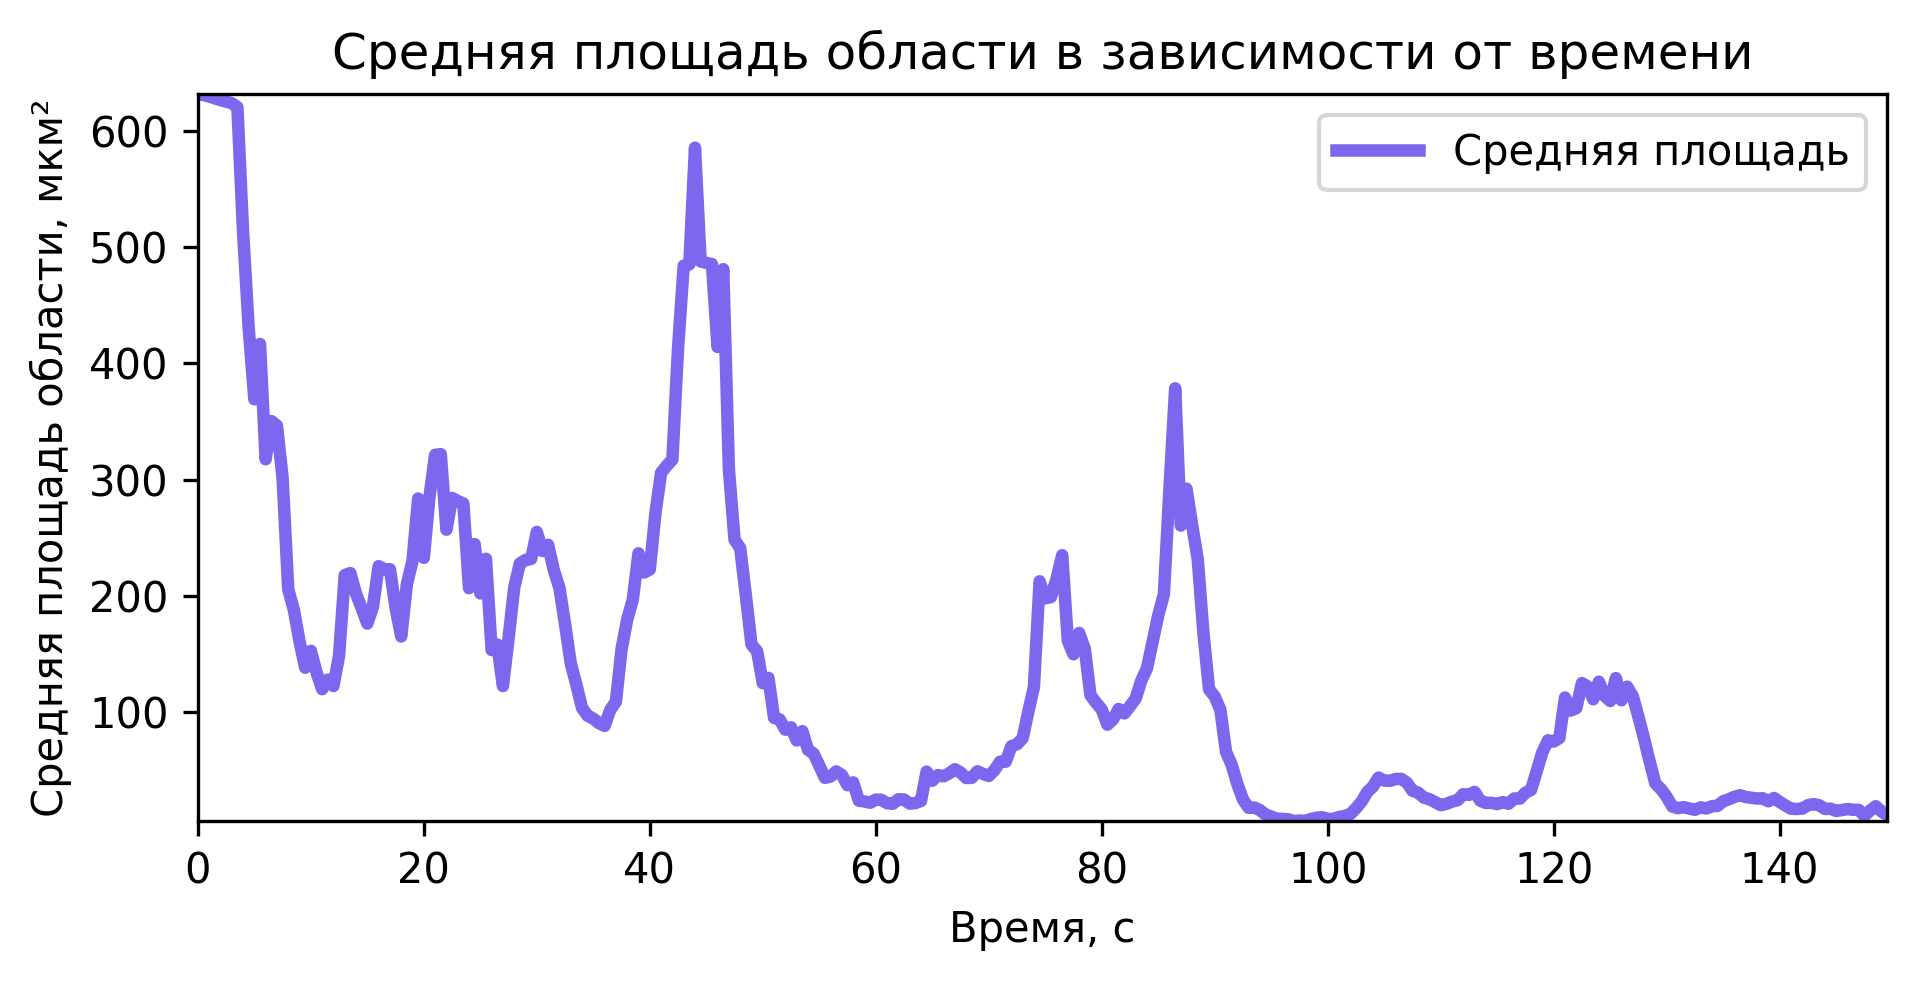

Mean Luminosity for folder: 2016-05-18_fileNo11_BM3D_z-max: = 12.92405297073141
     time_seconds  average_area
0             0.0    631.268743
1             0.5    630.630527
2             1.0    629.323337
3             1.5    627.812380
4             2.0    626.339869
..            ...           ...
295         147.5     10.946339
296         148.0     15.502135
297         148.5     19.225939
298         149.0     14.901151
299         149.5     11.397860

[300 rows x 2 columns]
Data saved to luminosity_2016-05-18_fileNo11_BM3D_z-max.xlsx
Data saved to luminosity.xlsx


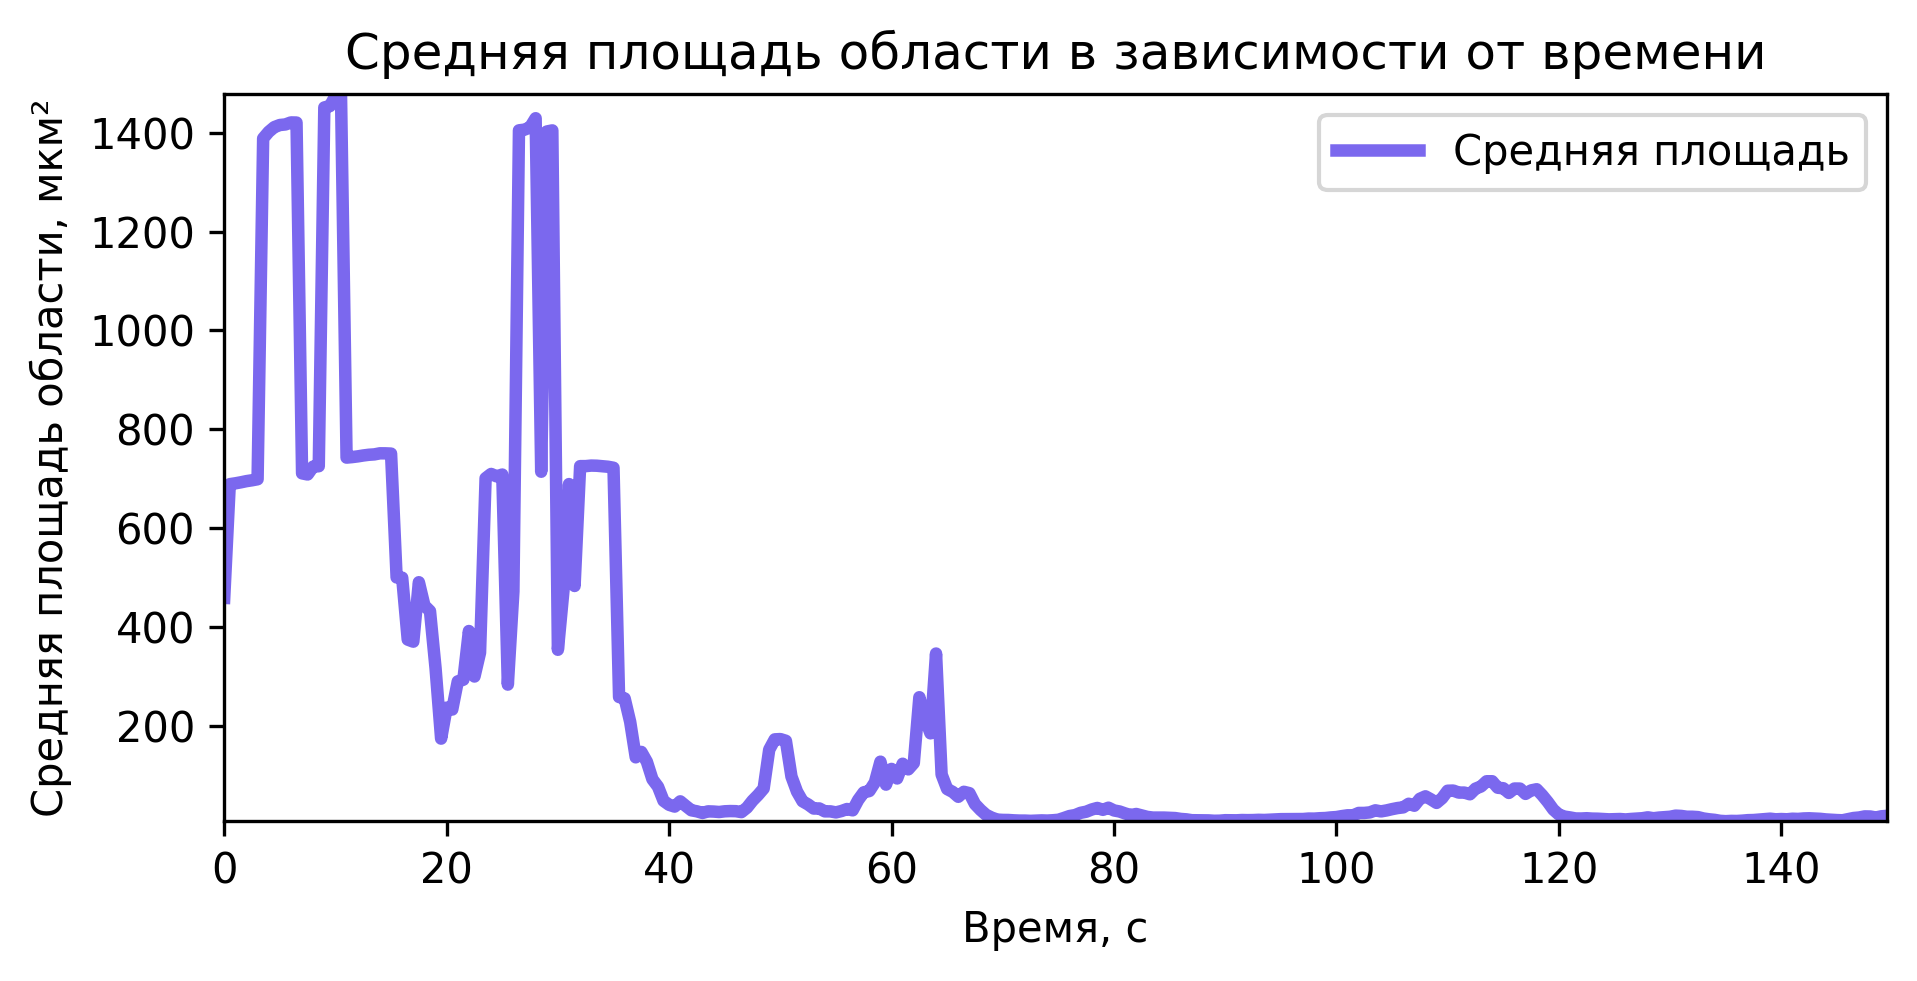

Mean Luminosity for folder: 2016-05-26_fileNo32_BM3D_z-max: = 19.271568142555665
     time_seconds  average_area
0             0.0    458.592849
1             0.5    688.840830
2             1.0    690.522876
3             1.5    692.579777
4             2.0    694.934641
..            ...           ...
295         147.5     16.033577
296         148.0     15.796809
297         148.5     13.786196
298         149.0     16.220006
299         149.5     17.155167

[300 rows x 2 columns]
Data saved to luminosity_2016-05-26_fileNo32_BM3D_z-max.xlsx
Data saved to luminosity.xlsx


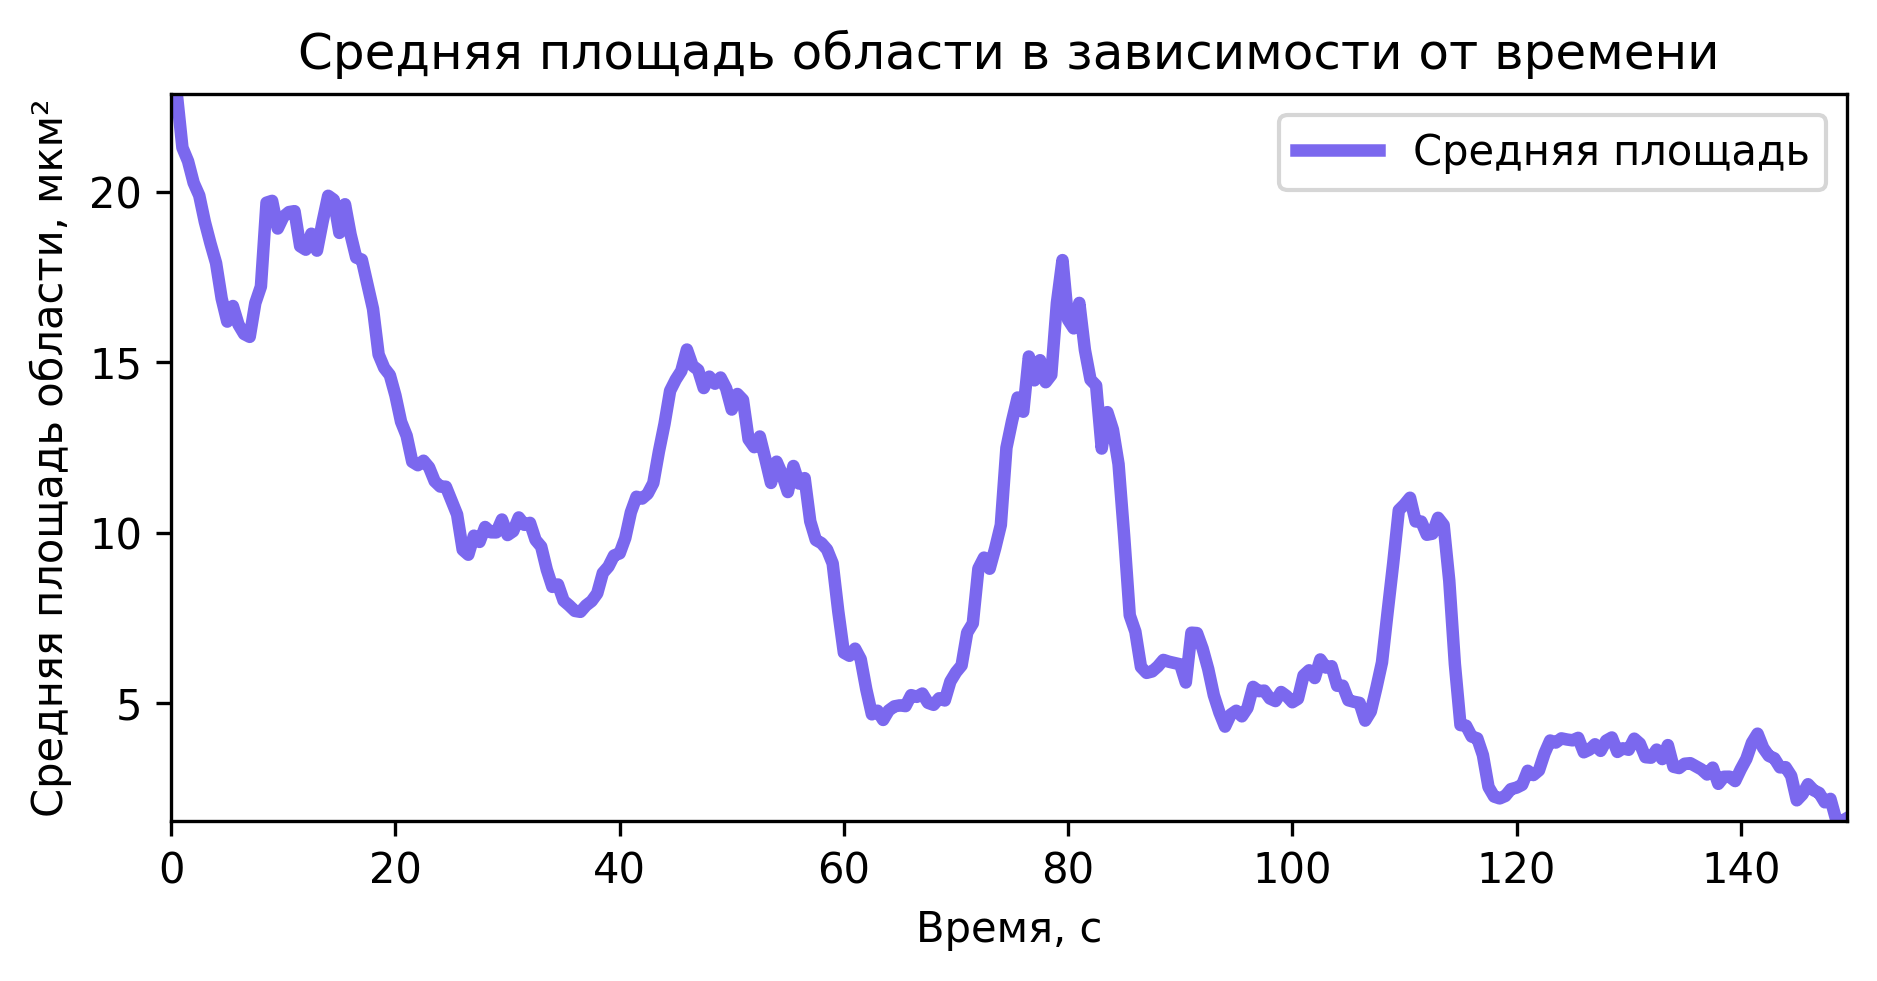

Mean Luminosity for folder: 31_08_2020_tser1: = 116.67587874039641
     time_seconds  average_area
0             0.0     22.645400
1             0.5     22.871812
2             1.0     21.304493
3             1.5     20.907886
4             2.0     20.272972
..            ...           ...
295         147.5      2.089196
296         148.0      2.190549
297         148.5      1.594704
298         149.0      1.536039
299         149.5      1.628928

[300 rows x 2 columns]
Data saved to luminosity_31_08_2020_tser1.xlsx
Data saved to luminosity.xlsx


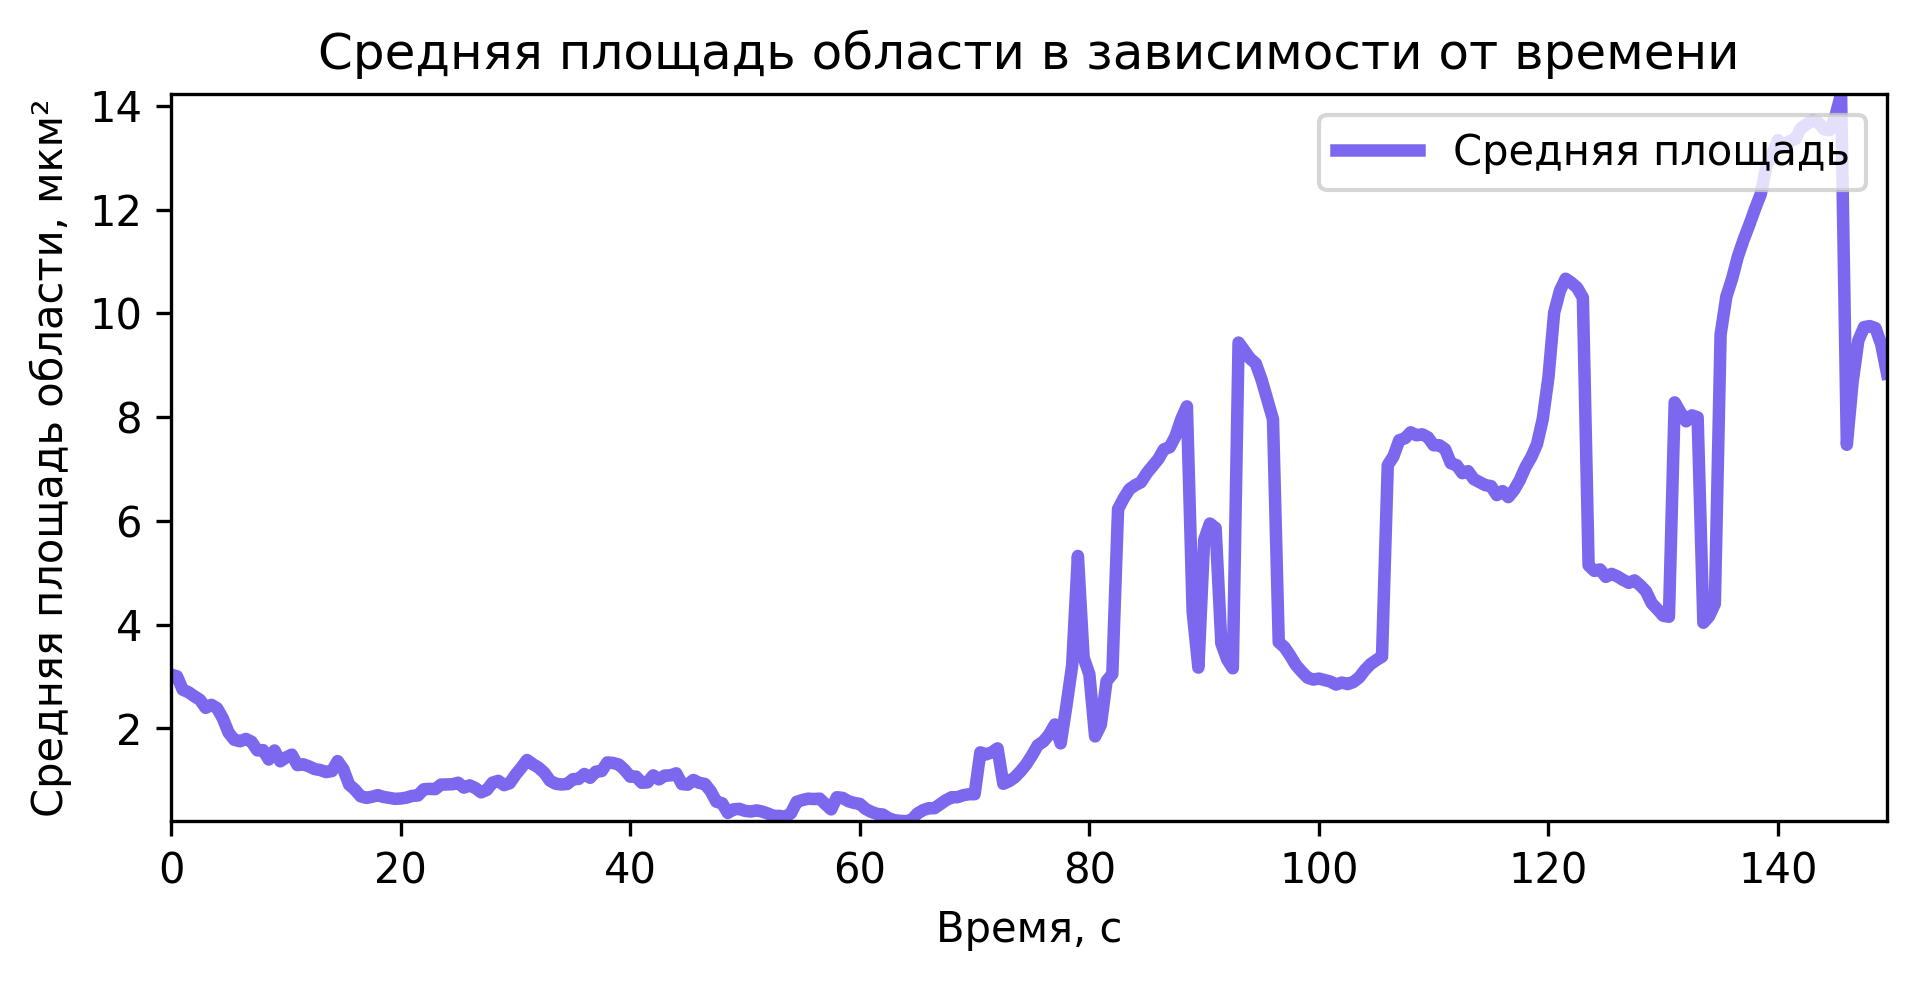

Mean Luminosity for folder: 31_08_2020_tser2: = 179.73507179130354
     time_seconds  average_area
0             0.0      3.035815
1             0.5      3.004022
2             1.0      2.746197
3             1.5      2.697452
4             2.0      2.621931
..            ...           ...
295         147.5      9.736640
296         148.0      9.755863
297         148.5      9.717416
298         149.0      9.400231
299         149.5      8.842753

[300 rows x 2 columns]
Data saved to luminosity_31_08_2020_tser2.xlsx
Data saved to luminosity.xlsx


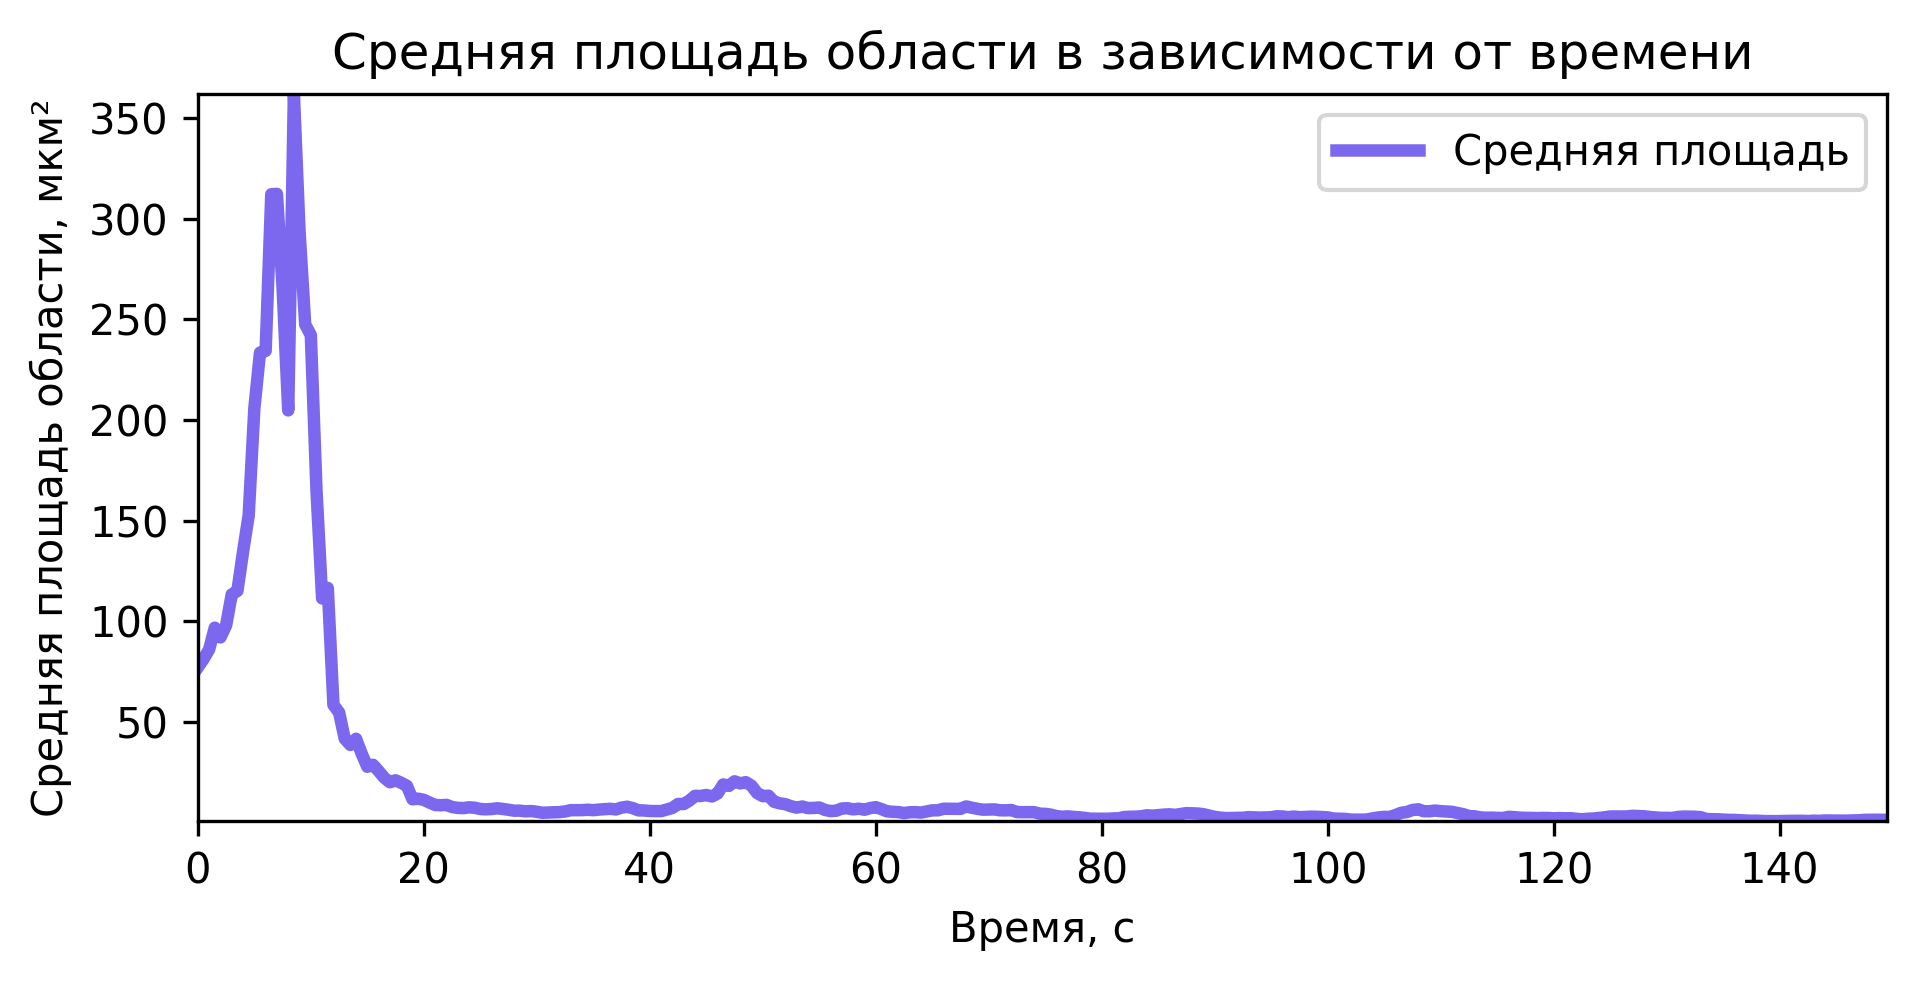

Mean Luminosity for folder: 31_08_2020_tser3: = 129.18105135701595
     time_seconds  average_area
0             0.0     77.159884
1             0.5     81.245675
2             1.0     86.038771
3             1.5     96.857543
4             2.0     92.008416
..            ...           ...
295         147.5      1.420782
296         148.0      1.450491
297         148.5      1.473210
298         149.0      1.438258
299         149.5      1.403306

[300 rows x 2 columns]
Data saved to luminosity_31_08_2020_tser3.xlsx
Data saved to luminosity.xlsx


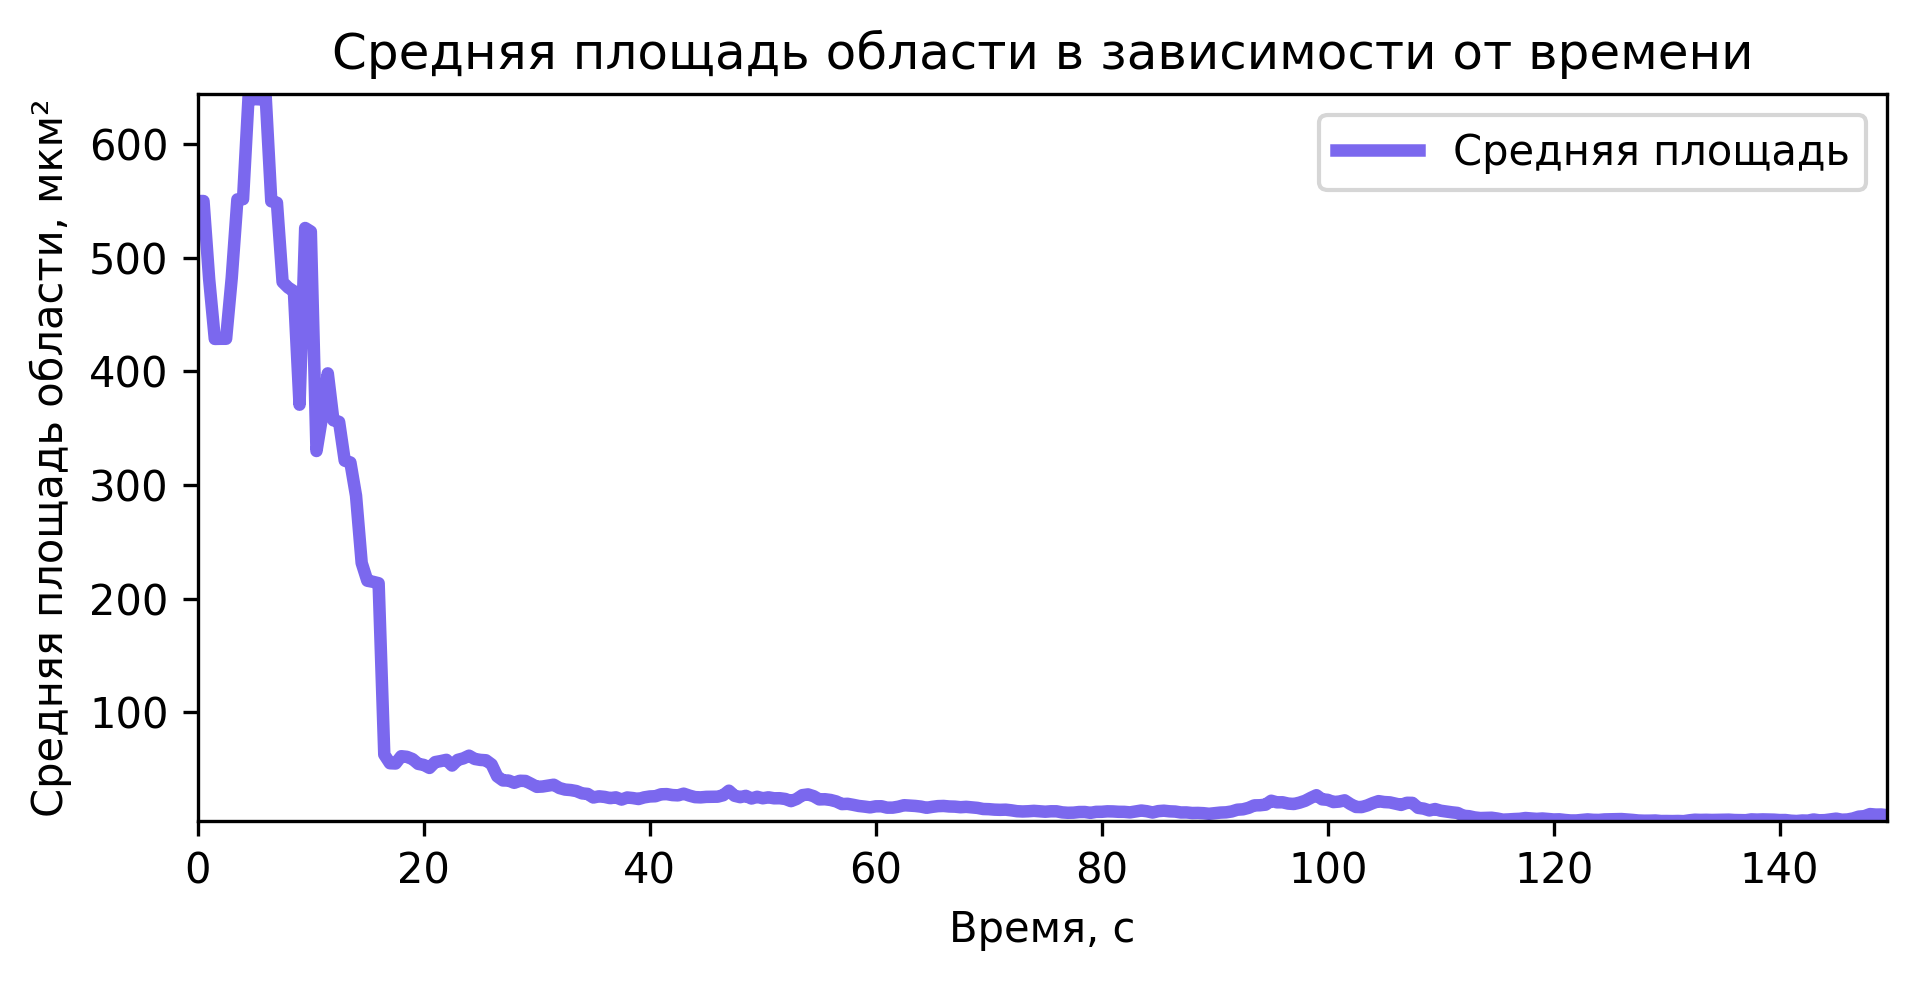

Mean Luminosity for folder: 31_08_2020_tser4: = 92.96948783485392
     time_seconds  average_area
0             0.0    549.961553
1             0.5    549.986269
2             1.0    481.271626
3             1.5    428.612927
4             2.0    428.736811
..            ...           ...
295         147.5      8.496732
296         148.0     10.330505
297         148.5      9.894073
298         149.0      9.949470
299         149.5      9.340572

[300 rows x 2 columns]
Data saved to luminosity_31_08_2020_tser4.xlsx
Data saved to luminosity.xlsx
                      Folder Name  Mean Luminosity
0  2016-05-18_fileNo11_BM3D_z-max        12.924053
1  2016-05-26_fileNo32_BM3D_z-max        19.271568
2                31_08_2020_tser1       116.675879
3                31_08_2020_tser2       179.735072
4                31_08_2020_tser3       129.181051
5                31_08_2020_tser4        92.969488


In [10]:
main_folder_path ='C:/Astro/Task Astrocytes'
run_all_functions(main_folder_path)

In [2]:
from my_package import create_folders_lists, read_dataframe, calculate_white_area_stats, add_white_area_info_to_df, graph_average_area, save_graph, save_data_average_area, calculate_mean_luminosity, save_luminosity_to_excel, create_luminosity_dataframe, run_all_functions

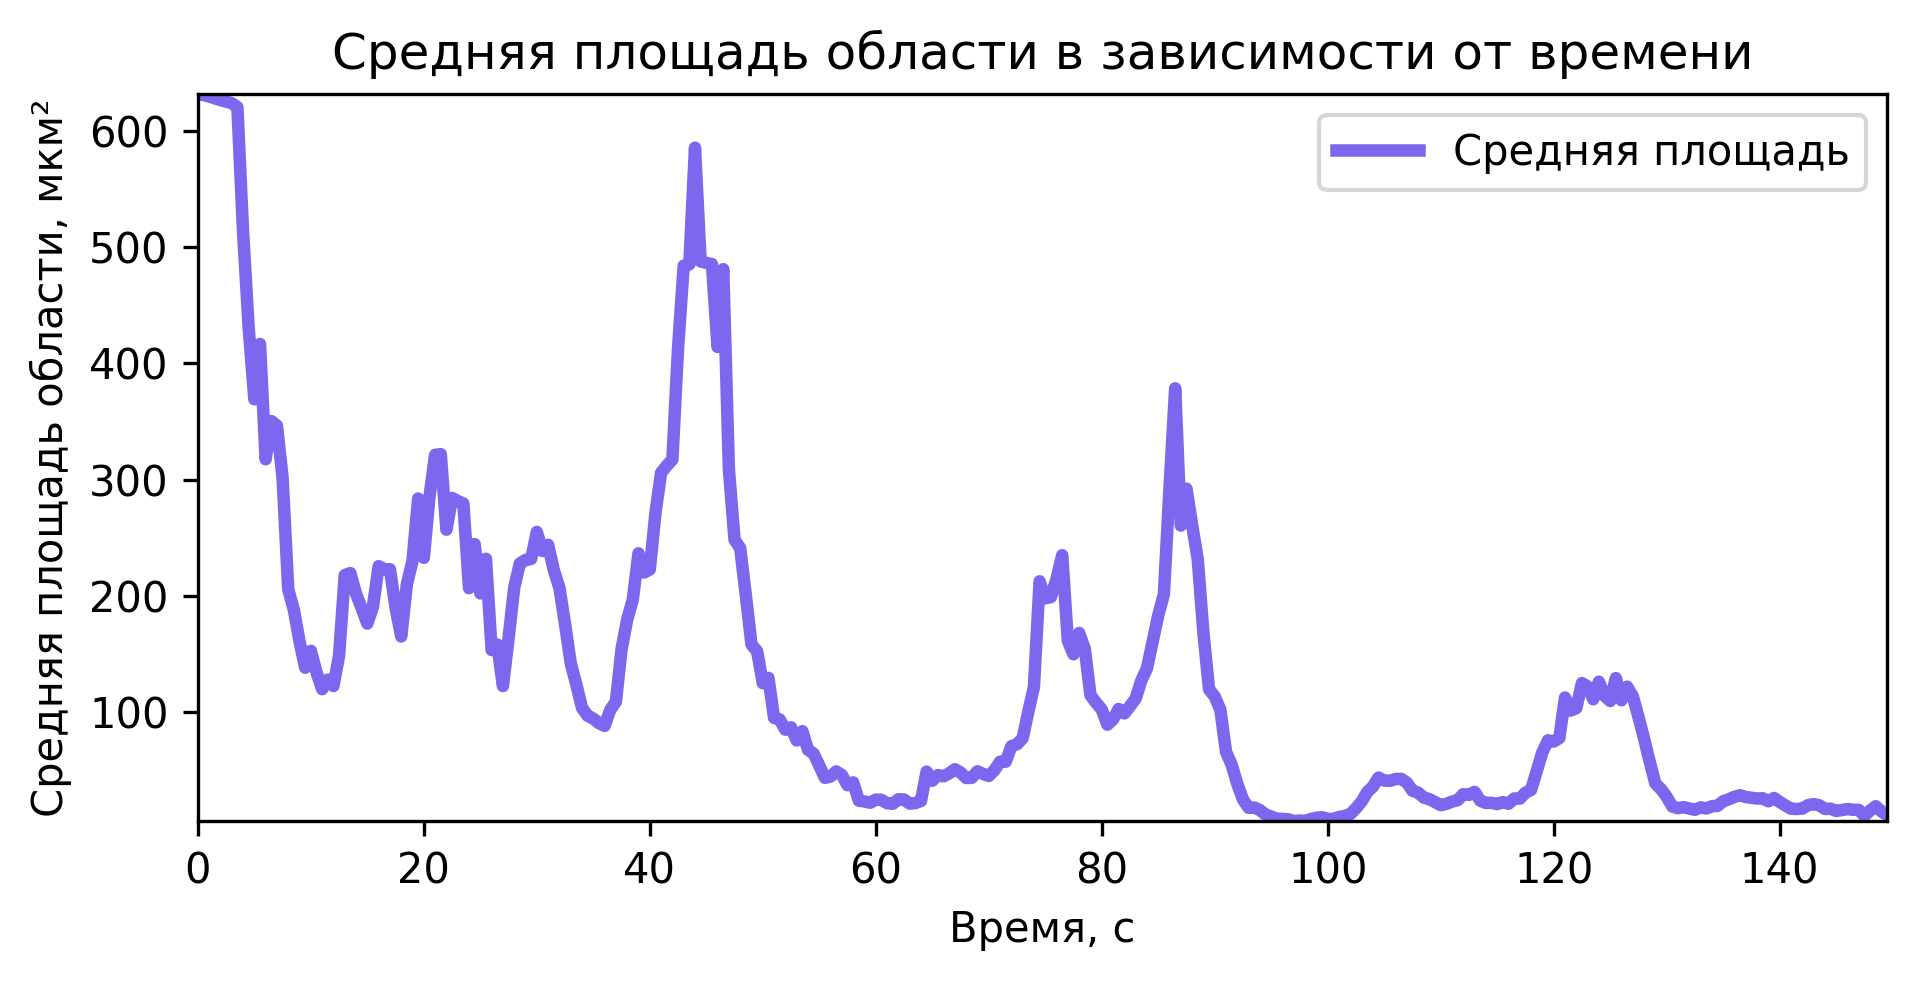

Mean Luminosity for folder: 2016-05-18_fileNo11_BM3D_z-max: = 12.92405297073141
     time_seconds  average_area
0             0.0    631.268743
1             0.5    630.630527
2             1.0    629.323337
3             1.5    627.812380
4             2.0    626.339869
..            ...           ...
295         147.5     10.946339
296         148.0     15.502135
297         148.5     19.225939
298         149.0     14.901151
299         149.5     11.397860

[300 rows x 2 columns]
Data saved to luminosity_2016-05-18_fileNo11_BM3D_z-max.xlsx
Data saved to luminosity.xlsx


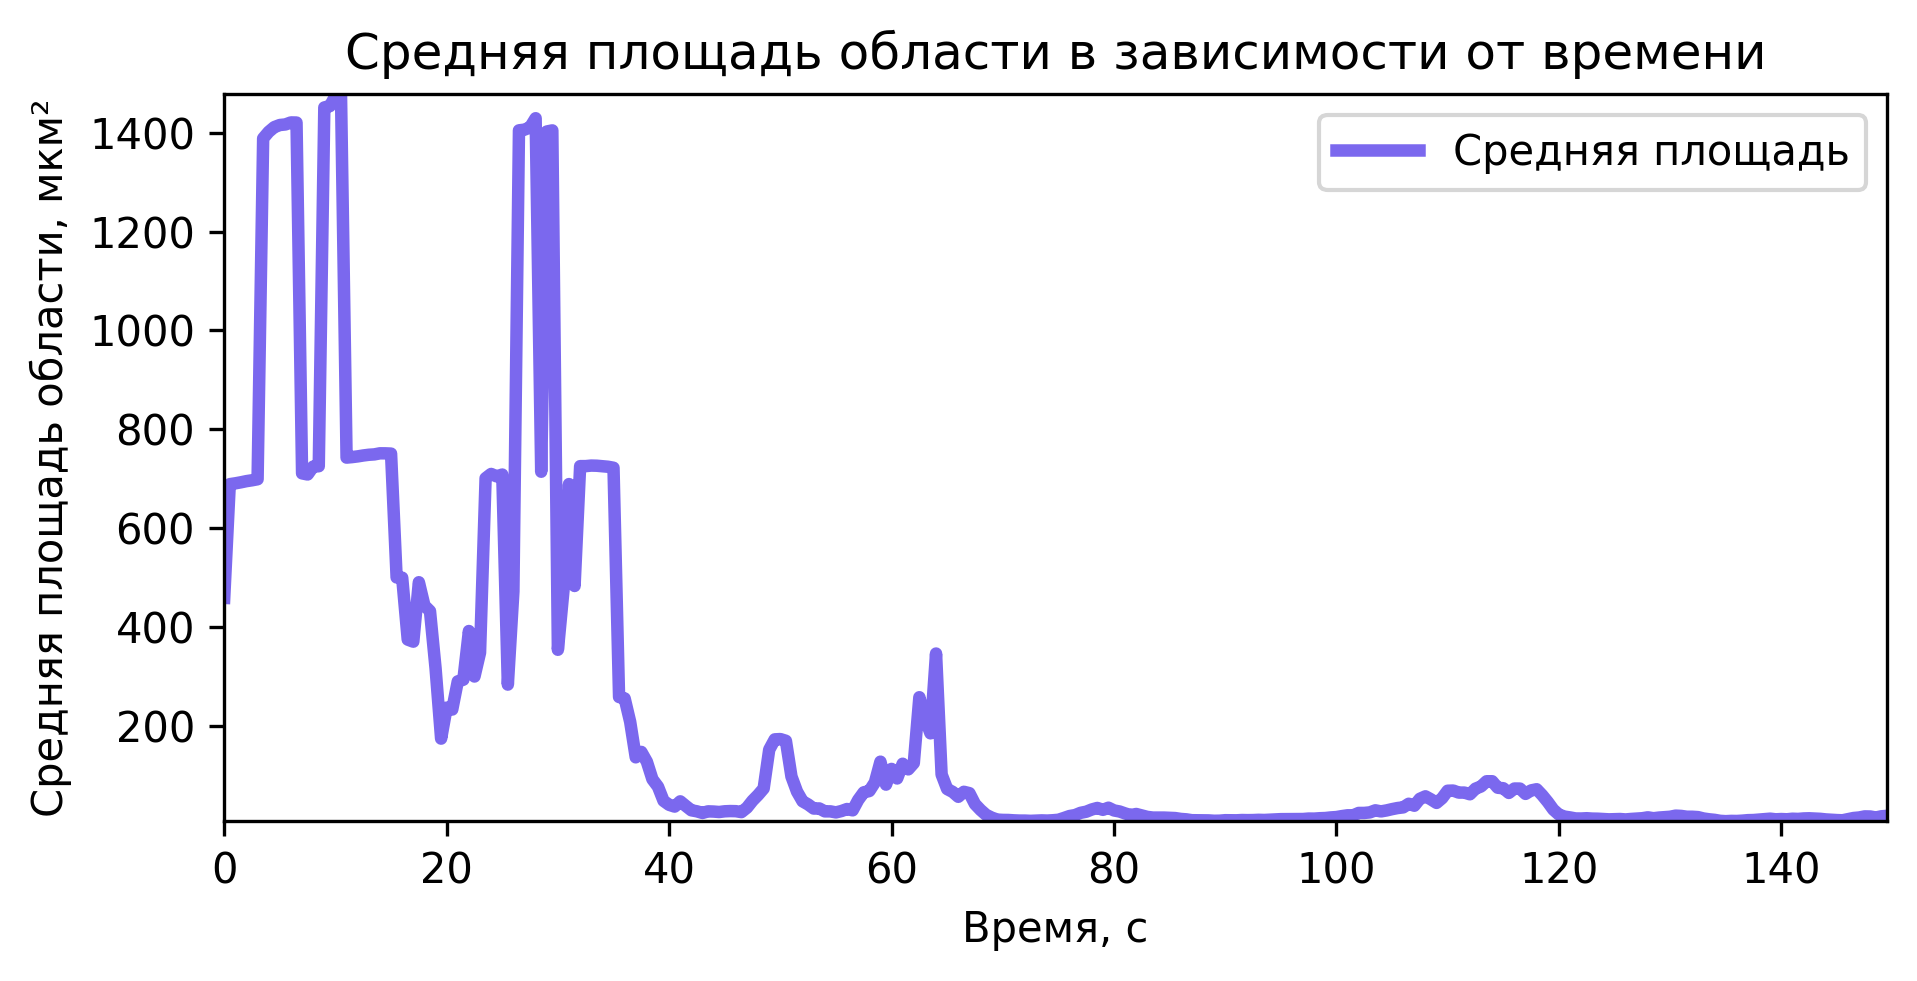

Mean Luminosity for folder: 2016-05-26_fileNo32_BM3D_z-max: = 19.271568142555665
     time_seconds  average_area
0             0.0    458.592849
1             0.5    688.840830
2             1.0    690.522876
3             1.5    692.579777
4             2.0    694.934641
..            ...           ...
295         147.5     16.033577
296         148.0     15.796809
297         148.5     13.786196
298         149.0     16.220006
299         149.5     17.155167

[300 rows x 2 columns]
Data saved to luminosity_2016-05-26_fileNo32_BM3D_z-max.xlsx
Data saved to luminosity.xlsx


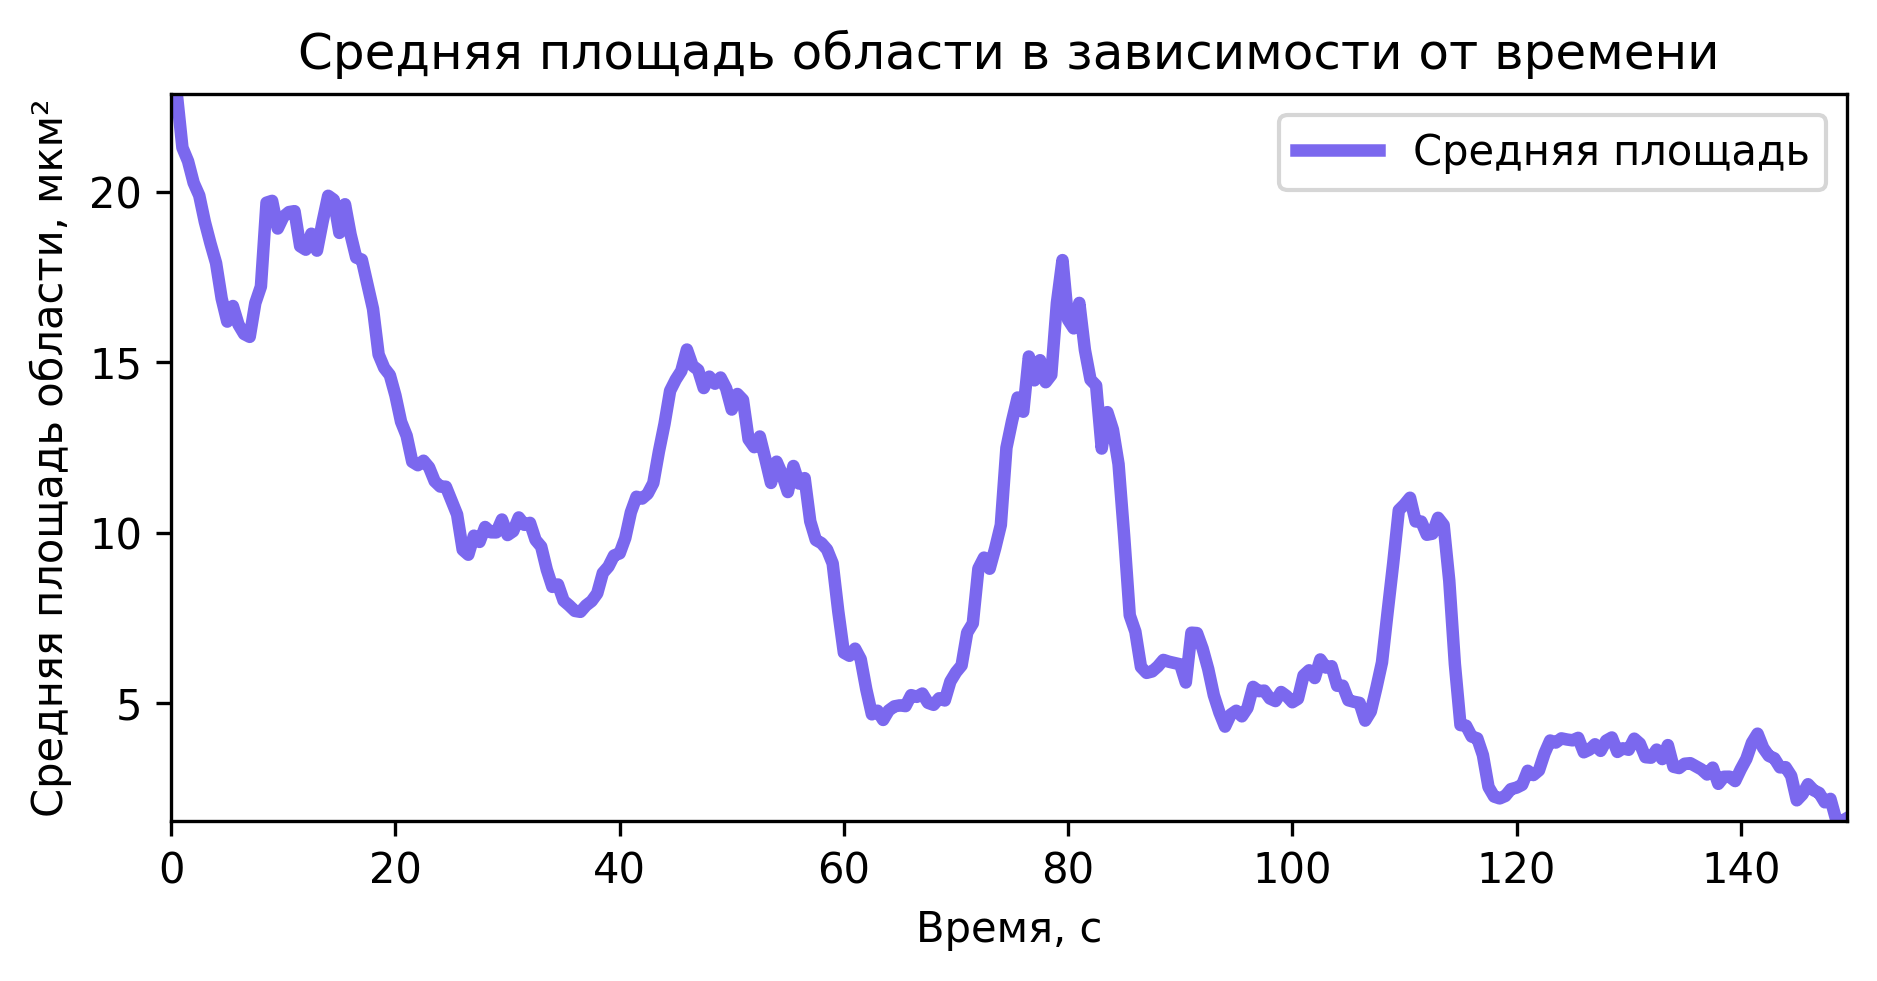

Mean Luminosity for folder: 31_08_2020_tser1: = 116.67587874039641
     time_seconds  average_area
0             0.0     22.645400
1             0.5     22.871812
2             1.0     21.304493
3             1.5     20.907886
4             2.0     20.272972
..            ...           ...
295         147.5      2.089196
296         148.0      2.190549
297         148.5      1.594704
298         149.0      1.536039
299         149.5      1.628928

[300 rows x 2 columns]
Data saved to luminosity_31_08_2020_tser1.xlsx
Data saved to luminosity.xlsx


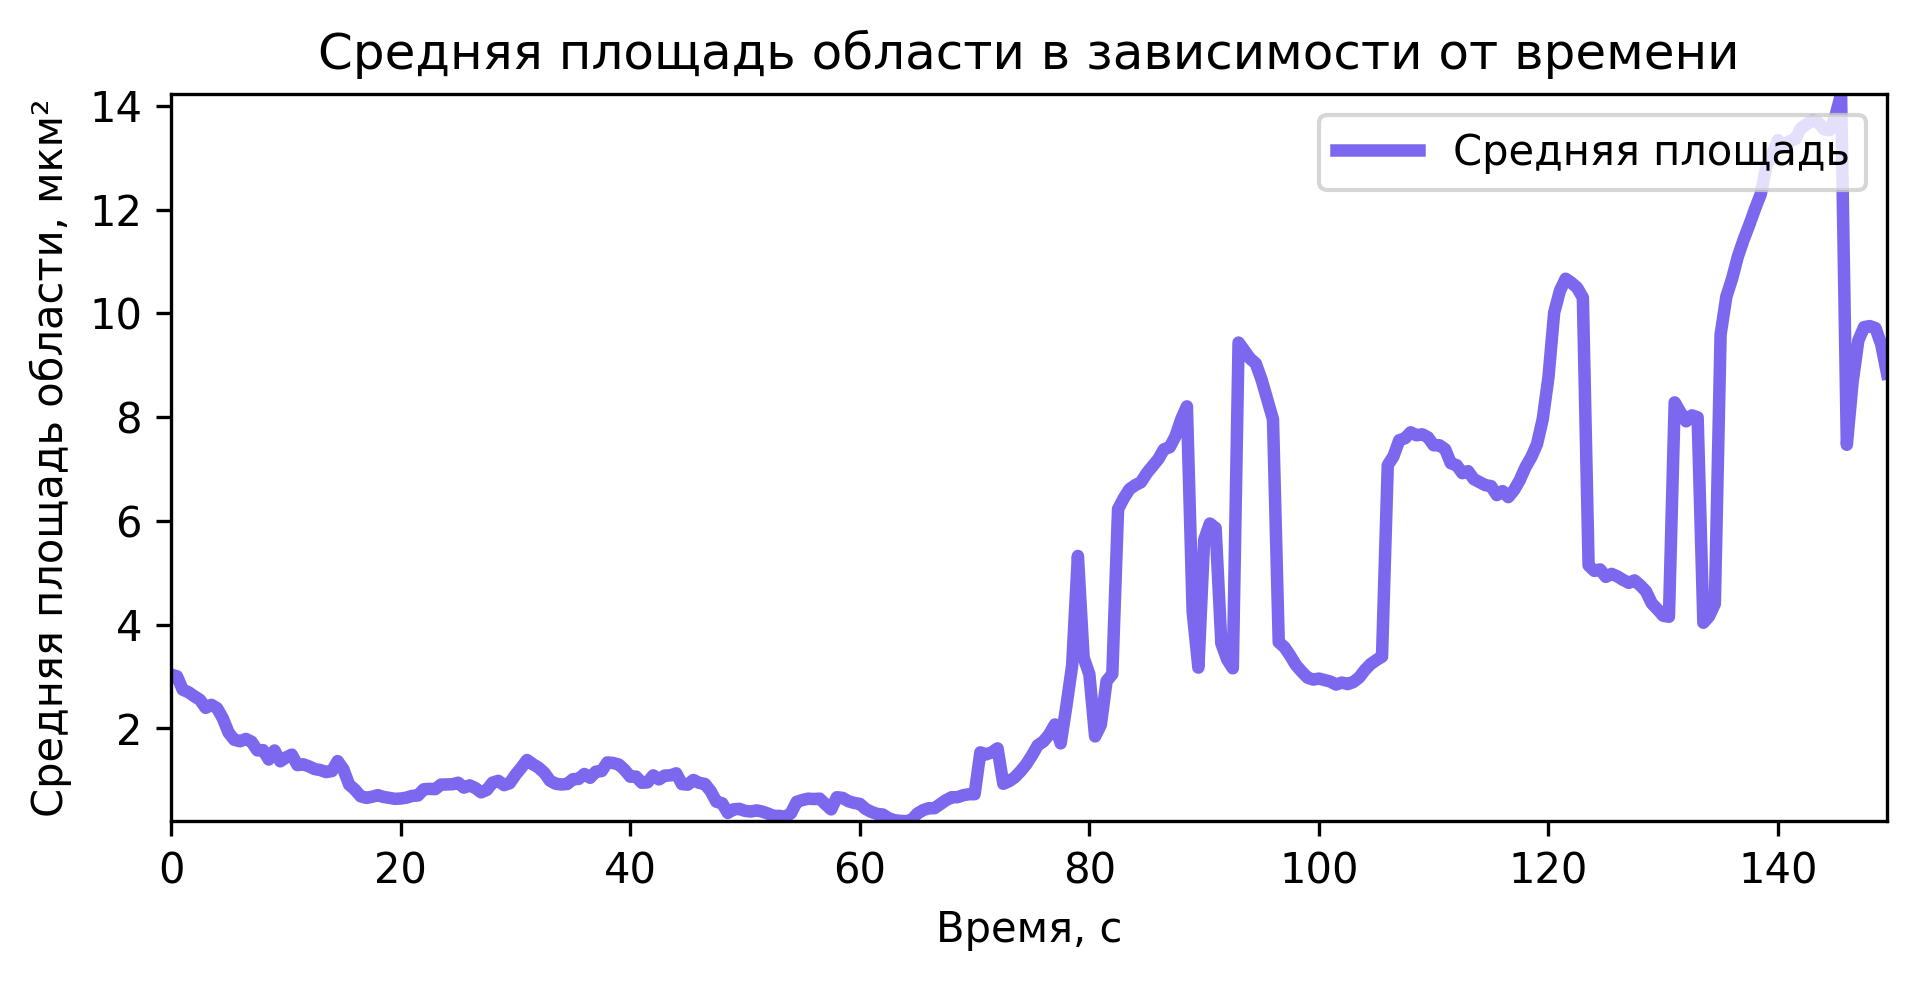

Mean Luminosity for folder: 31_08_2020_tser2: = 179.73507179130354
     time_seconds  average_area
0             0.0      3.035815
1             0.5      3.004022
2             1.0      2.746197
3             1.5      2.697452
4             2.0      2.621931
..            ...           ...
295         147.5      9.736640
296         148.0      9.755863
297         148.5      9.717416
298         149.0      9.400231
299         149.5      8.842753

[300 rows x 2 columns]
Data saved to luminosity_31_08_2020_tser2.xlsx
Data saved to luminosity.xlsx


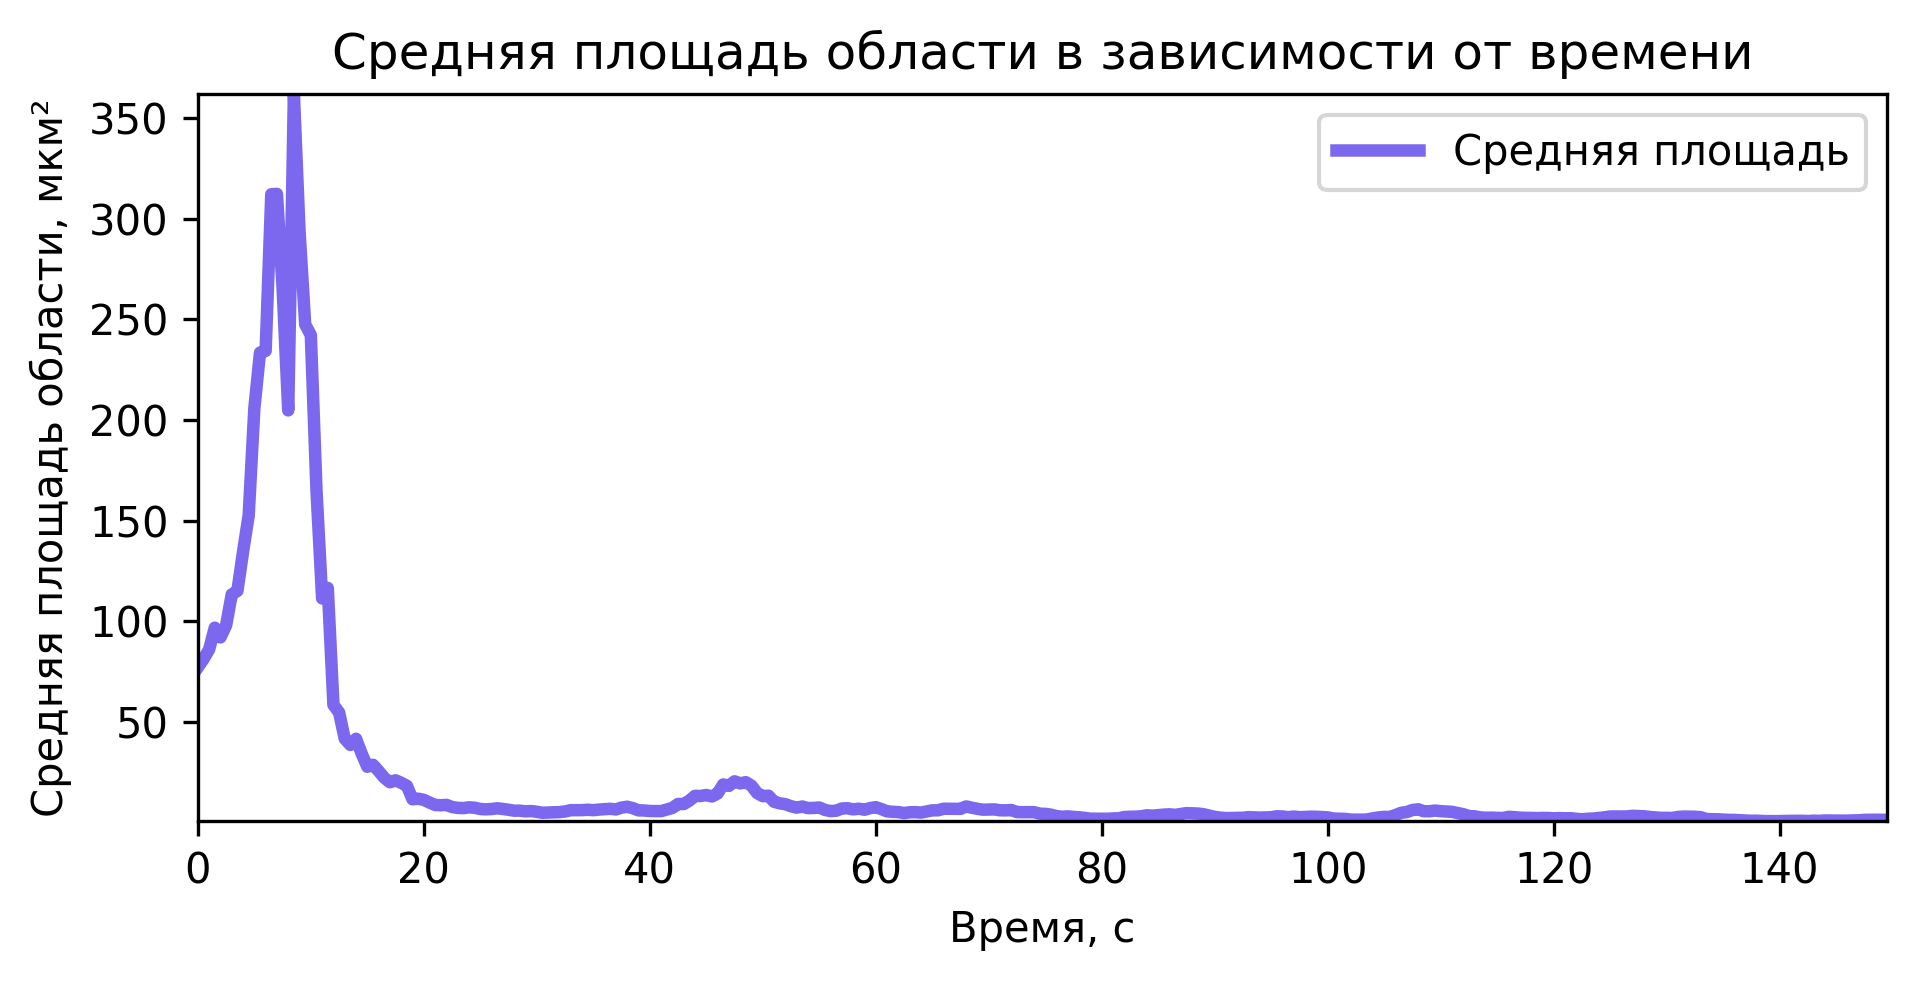

Mean Luminosity for folder: 31_08_2020_tser3: = 129.18105135701595
     time_seconds  average_area
0             0.0     77.159884
1             0.5     81.245675
2             1.0     86.038771
3             1.5     96.857543
4             2.0     92.008416
..            ...           ...
295         147.5      1.420782
296         148.0      1.450491
297         148.5      1.473210
298         149.0      1.438258
299         149.5      1.403306

[300 rows x 2 columns]
Data saved to luminosity_31_08_2020_tser3.xlsx
Data saved to luminosity.xlsx


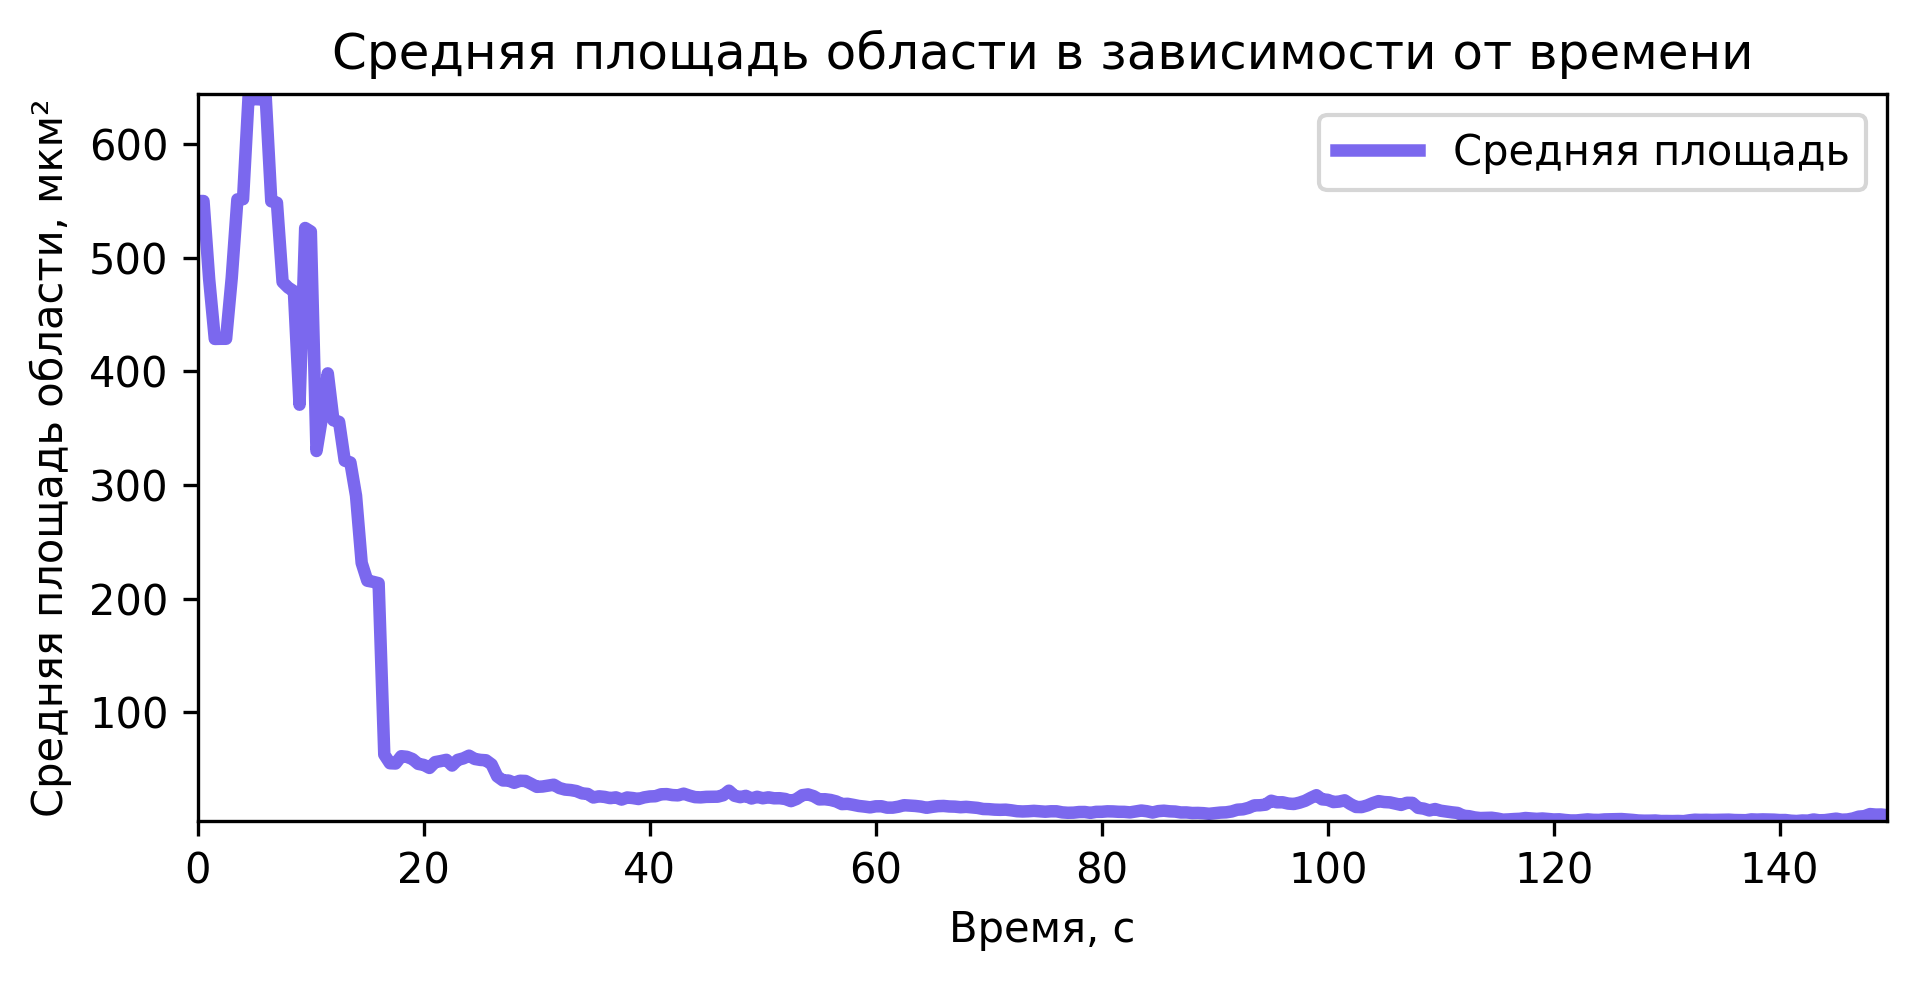

Mean Luminosity for folder: 31_08_2020_tser4: = 92.96948783485392
     time_seconds  average_area
0             0.0    549.961553
1             0.5    549.986269
2             1.0    481.271626
3             1.5    428.612927
4             2.0    428.736811
..            ...           ...
295         147.5      8.496732
296         148.0     10.330505
297         148.5      9.894073
298         149.0      9.949470
299         149.5      9.340572

[300 rows x 2 columns]
Data saved to luminosity_31_08_2020_tser4.xlsx
Data saved to luminosity.xlsx
                      Folder Name  Mean Luminosity
0  2016-05-18_fileNo11_BM3D_z-max        12.924053
1  2016-05-26_fileNo32_BM3D_z-max        19.271568
2                31_08_2020_tser1       116.675879
3                31_08_2020_tser2       179.735072
4                31_08_2020_tser3       129.181051
5                31_08_2020_tser4        92.969488


In [3]:
import my_package

main_path = 'C:/Astro/Task Astrocytes'

# Вызов функции run_all_functions из пакета
result = run_all_functions(main_path)

##### Ссылка на репозиторий

[https://github.com/lenelbel/Astro.git](https://github.com/lenelbel/Astro.git)

### Сылка на отчет
[https://docs.google.com/document/d/1oL1lyvgcfMSxO_nYVTDt1FR6BN040eiN/edit?usp=sharing&ouid=116982402004737139497&rtpof=true&sd=true](https://docs.google.com/document/d/1oL1lyvgcfMSxO_nYVTDt1FR6BN040eiN/edit?usp=sharing&ouid=116982402004737139497&rtpof=true&sd=true)